In [1]:
!nvidia-smi

Thu Dec  9 10:45:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   43C    P0    42W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [4]:
data_dir='/gpfsscratch/rech/qrc/commun/tensorflow_datasets'

In [5]:
from sfh.datasets.mergers import kinetic

In [7]:
from astropy.stats import mad_std
import numpy as np

def mean_std_computation(img,lbt):      
    scaling = []
    mean_img = []
    #img = np.nan_to_num(img, copy=Tru, nan=0.0)
    img[np.isnan(img)] = 0
    img[np.isinf(img)] = 0
    for i in range(0,img.shape[1]):
        sigma = mad_std(img[:,i,:,:].flatten())
        avg = np.mean(img[:,i,:,:].flatten())
        scaling.append(sigma)
        mean_img.append(avg)
    return mean_img, scaling

In [35]:
# Using a mapping function to apply preprocessing to our data
def preprocessing(example):
    a = 3.
    img1 = tf.constant(1/a,dtype=tf.float32) * tf.math.asinh(example['image'][0,:,:]/(tf.constant(scaling[0]*a,dtype=tf.float32)) )
    img2 = (example['image'][1,:,:]-tf.constant(mean_img[1],dtype=tf.float32))/tf.constant(scaling[1],dtype=tf.float32)
    img3 = (example['image'][2,:,:]-tf.constant(mean_img[2],dtype=tf.float32))/tf.constant(scaling[2],dtype=tf.float32)
    img  = tf.stack([img1,img2,img3],axis=0)
    lbt = example['last_major_merger']/tf.constant(13.6)    
    return dict(image=img, last_major_merger =lbt, object_id=example['object_id'])

In [36]:
def stack_vars(ds):
    images =[]
    lbt = []
    for i, entry in enumerate(ds): 
        images.append(entry['image'])
        lbt.append(entry['last_major_merger'])
    images = np.stack(images)
    lbt = np.stack(lbt)
    return images, lbt

In [37]:
ds = tfds.load('mergers_kinetic', split='train[:1%]', data_dir=data_dir)

In [38]:
print(len(ds))

252


In [39]:
N = 10

ds = ds.take(N)

In [40]:
print(len(ds))

10


In [41]:
images, lbt =  stack_vars(ds)   
print('stacked_images:', shape(images))
print('stacked_lbt:', shape(lbt))

stacked_images: (10, 3, 512, 512)
stacked_lbt: (10,)


In [42]:
mean_img, scaling = mean_std_computation(images,lbt)
print("sigma:", scaling)
print("mean:", mean_img)

sigma: [33205.43648882585, 43.65749262641268, 37.643232661037565]
mean: [193696.55, 2.9481435, 95.614685]


In [43]:
dset = ds.map(preprocessing)

In [45]:
images_scaled,lbt_scaled = stack_vars(dset)

(-0.5, 511.5, 511.5, -0.5)

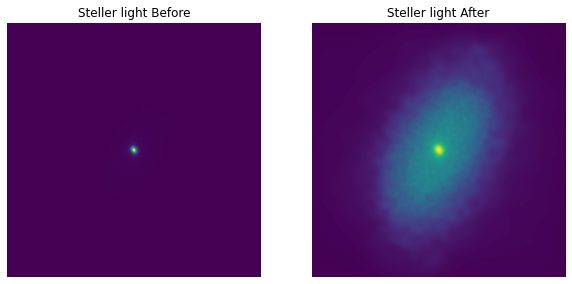

In [46]:
sample = 1 

plt.figure(figsize=(10,30))

plt.subplot(1,2,1)
plt.imshow(images[sample,0,:,:])
plt.title('Steller light Before')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(images_scaled[sample,0,:,:])
plt.title( 'Steller light After')
plt.axis('off')